### Load All Necessary Packages

In [8]:
import pandas as pd
# !pip install gseapy
import seaborn as sns
import gseapy as gp
from collections import Counter
from scipy.stats import linregress
import psycopg2
import os
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
# ! pip install lifelines
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

In [17]:
os.chdir('/Users/haider/Desktop/Biomedical Data Science I/')
os.getcwd()

'/Users/haider/Desktop/Biomedical Data Science I'

### Load Breast Cancer Clinical Dataset and Associated Genomic Dataset

In [4]:
mutations_breast_cancer = pd.read_csv('/Users/haider/Desktop/Biomedical Data Science I/breast_msk_2018/data_mutations.csv')
clinical_breast_cancer = pd.read_csv('/Users/haider/Desktop/Biomedical Data Science I/breast_msk_2018_clinical_data.csv')

### Data Cleaning, Data Modelling and Exploratory Analysis

##### Determine The Primary and Foreign Keys

In [18]:
# Create the Data profile

# Logical Data Type helper function
# Function to infer logical data type
def infer_log_dtype(cols):
    if pd.api.types.is_bool_dtype(cols):
        return "Boolean"
    elif pd.api.types.is_numeric_dtype(cols):
        return "Numeric"
    elif pd.api.types.is_datetime64_any_dtype(cols):
        return "Date/Time"
    elif cols.nunique() == len(cols):
        return "Identifier"
    else:
        return "Categorical/Text"

# Step 2: Use a for loop to go through each column. Inside the loop, calculate values and append
def create_data_profile(df):
    Column_name = []
    Log_Data_type = []
    Data_type=[]
    Row_count =[]
    Num_Dist = []
    Null_count =[]
    perc_null = []
    for cols in df.columns:
        Column_name.append(cols)
        Log_Data_type.append(infer_log_dtype(df[cols]))
        Data_type.append(df[cols].dtypes)
        Row_count.append(df[cols].shape[0])
        Num_Dist.append(df[cols].nunique())
        Null_count.append(df[cols].isnull().sum())
        perc_null.append((df[cols].isnull().sum()/df.shape[0])*100)
    # Step 3: After the loop, combine lists into a DataFrame
    data_profile = pd.DataFrame({
        "Column_name": Column_name,
        "Log_Data_type": Log_Data_type,
        "Data_type": Data_type,
        "Row_count":Row_count,
        "Num_Dist":Num_Dist,
        "Null_count":Null_count,
        "perc_null":perc_null})
    return data_profile

In [5]:
# create_data_profile(mutations_breast_cancer)
# The Sample ID is unique and matches the row counts. This would be your Primary Key in the Clinical Dataset

In [41]:
# create_data_profile(clinical_breast_cancer)
# The Tumour_Sample_Barcode would be the foreign key in the genomic dataset
# The genomic dataset does not have primary key

##### Select Top KEGG pathways from the Complementary Dataset to combined with the Primary dataset

In [48]:
# Extract Hugo Symbols and group them by Sample ID
df_breast_mutation = mutations_breast_cancer.groupby('Tumor_Sample_Barcode')['Hugo_Symbol'].agg(', '.join).reset_index()

In [49]:
# Split genes into list form
df_breast_mutation["Gene_List"] = df_breast_mutation["Hugo_Symbol"].str.replace(" ", "").str.split(",")

In [50]:
# Flatten unique genes
all_genes = sorted(set(sum(df_breast_mutation["Gene_List"].tolist(), [])))

In [51]:
# KEGG annotations
# GSEAPY can retrieve KEGG pathway mappings from Enrichr
enrichr = gp.enrichr(gene_list=all_genes, gene_sets="KEGG_2021_Human", organism="Human")

# Create a gene to associated KEGG pathway dictionary
gene_to_kegg = {}
for _, row in enrichr.results.iterrows():
    genes = [g.strip() for g in row["Genes"].split(";")]
    for g in genes:
        gene_to_kegg.setdefault(g, []).append(row["Term"])

# Map KEGG pathways to each row 
def map_pathways(genes):
    return list({p for g in genes for p in gene_to_kegg.get(g, [])})

df_breast_mutation["KEGG_Pathways"] = df_breast_mutation["Gene_List"].apply(map_pathways)


In [52]:
# Convert the Kegg Pathway Column to a list
pathways_list=df_breast_mutation['KEGG_Pathways'].tolist()
pathways_flat_list= sum(pathways_list, [])


In [53]:
# Create a Frequency Table of the Top Pathways Associated with the Breast Cancer Dataset
Disease_freq=Counter(pathways_flat_list)
Disease_freq_table = pd.DataFrame(Disease_freq.items(), columns=['Disease_Pathway', 'Freq'])
Disease_freq_table=Disease_freq_table.sort_values(by='Freq',ascending=False)
Disease_freq_table.head(15)

# Thyroid signalling pathway
# Central carbon metabolism in cancer
# cellular senescence
# Proteoglycans in cancer
# Human T-cell leukemia virus 1 infection
# PI3K-Akt signaling pathway
# HPV

Disease_Pathway  Freq
60                       Pathways in cancer  1637
67                            Breast cancer  1530
99               PI3K-Akt signaling pathway  1502
44                       Endometrial cancer  1482
27                           Gastric cancer  1480
2                       MicroRNAs in cancer  1473
39                 Hepatocellular carcinoma  1472
41                                 Melanoma  1471
14                  Proteoglycans in cancer  1468
49           Human papillomavirus infection  1465
66  Human T-cell leukemia virus 1 infection  1462
42                          Prostate cancer  1457
74        Thyroid hormone signaling pathway  1442
53      Central carbon metabolism in cancer  1433
58                      Cellular senescence  1409

In [ ]:
df_breast_mutation.to_csv("df_breast_mutation.csv")

In [54]:
# Add a new column that indicates whether a sampl ID has the pathways of interest
thyroid = []
carb_metab =[]
ptglc = []
cell_sen =[]
human_T=[]
PI3k=[]
hpv=[]
Total_Pathway_Count=[]
for row in df_breast_mutation['KEGG_Pathways']:
    if "Thyroid hormone signaling pathway" in row:
        thyroid.append("Thyroid hormone signaling pathway")
    else:
        thyroid.append(None)

for row in df_breast_mutation['KEGG_Pathways']:
    if "Central carbon metabolism in cancer" in row:
        carb_metab.append("Central carbon metabolism in cancer")
    else:
        carb_metab.append(None)

for row in df_breast_mutation['KEGG_Pathways']:
    if "Cellular senescence" in row:
        cell_sen.append("Cellular senescence")
    else:
        cell_sen.append(None)

for row in df_breast_mutation['KEGG_Pathways']:
    if "Proteoglycans in cancer" in row:
        ptglc.append("Proteoglycans in cancer")
    else:
        ptglc.append(None)


for row in df_breast_mutation['KEGG_Pathways']:
    if 'Human T-cell leukemia virus 1 infection' in row:
        human_T.append("Human T-cell leukemia virus 1 infection")
    else:
        human_T.append(None)


for row in df_breast_mutation['KEGG_Pathways']:
    if "PI3K-Akt signaling pathway" in row:
        PI3k.append("PI3K-Akt signaling pathway")
    else:
        PI3k.append(None)

for row in df_breast_mutation['KEGG_Pathways']:
    if "Human papillomavirus infection" in row:
        hpv.append("Human papillomavirus infection")
    else:
        hpv.append(None)

for row in df_breast_mutation['KEGG_Pathways']:
    Total_Pathway_Count.append(len(row))



df_breast_mutation["Thyroid hormone signaling pathway"]=thyroid
df_breast_mutation["Central carbon metabolism in cancer"]=carb_metab
df_breast_mutation["Cellular senescence"]=cell_sen
df_breast_mutation["Proteoglycans in cancer"]=ptglc
df_breast_mutation['Human T-cell leukemia virus 1 infection']=human_T
df_breast_mutation["PI3K-Akt signaling pathway" ]=PI3k
df_breast_mutation[ "Human papillomavirus infection"]=hpv
df_breast_mutation['Total_Pathways']=Total_Pathway_Count



In [ ]:
df_breast_mutation_sub=df_breast_mutation[["Tumor_Sample_Barcode", "Thyroid hormone signaling pathway", "Central carbon metabolism in cancer", "Cellular senescence",
                                               "Proteoglycans in cancer", 'Human T-cell leukemia virus 1 infection', "PI3K-Akt signaling pathway",
                                                "Human papillomavirus infection", 'Total_Pathways']]

df_breast_mutation_sub.to_csv("df_breast_mutation_sub.csv")

In [20]:
df_breast_mutation_sub = pd.read_csv("df_breast_mutation_sub.csv")

In [430]:
df_breast_mutation[['Tumor_Sample_Barcode','Hugo_Symbol', 'KEGG_Pathways']]

Tumor_Sample_Barcode                                        Hugo_Symbol  \
0       P-0000004-T01-IM3                             SPEN, MLL3, AKT1, TP53   
1       P-0000012-T02-IM3                                               TP53   
2       P-0000015-T01-IM3        ALK, PIK3CA, ESR1, CDK4, TP53, RNF43, GATA3   
3       P-0000041-T01-IM3  FLT4, NOTCH4, ERBB4, PIK3CA, INPP4B, HGF, PIK3...   
4       P-0000057-T01-IM3               PIK3CA, BARD1, MAP3K13, NOTCH4, TP53   
...                   ...                                                ...   
1829    P-0018917-T01-IM6                       ARID5B, MAP2K4, PTPRS, KMT2B   
1830    P-0018963-T01-IM6                                               AKT1   
1831    P-0019037-T01-IM6                                       PIK3CA, CBFB   
1832    P-0019054-T01-IM6                                 PIK3CA, CDH1, CBFB   
1833    P-0019073-T01-IM6                                              PBRM1   

                                          KEGG_Pathways  
0     [cAMP signaling pathway, Wnt signaling pathway...  
1     [Human papillomavirus infection, Wnt signaling...  
2     [cAMP signaling pathway, Endocrine and other f...  
3     [cAMP signaling pathway, Wnt signaling pathway...  
4     [cAMP signaling pathway, Wnt signaling pathway...  
...                                                 ...  
1829  [Epithelial cell signaling in Helicobacter pyl...  
1830  [cAMP signaling pathway, VEGF signaling pathwa...  
1831  [cAMP signaling pathway, MicroRNAs in cancer, ...  
1832  [cAMP signaling pathway, MicroRNAs in cancer, ...  
1833                         [Hepatocellular carcinoma]  

[1834 rows x 3 columns]

##### Extracting Molecular/Tumour and Demographic Information for Merge

In [21]:
cancer_mol_demo = [
    # Primary key
    "Sample ID",
    # Demographic information
    "Invasive Carcinoma Diagnosis Age",
    "Primary Tumor Laterality",
    "Menopausal Status At Diagnosis",
    "Sex",
    "Prior Breast Primary",
    "Prior Local Recurrence",

    # Molecular / Tumor information
    "M Stage",
    "N Stage",
    "T Stage",
    "Mutation Count",
    "TMB (nonsynonymous)",
    "Tumor Sample Histology",
    "Metastatic Disease at Last Follow-up",
    "Metastatic Recurrence Time",

    # Outcome / Survival information
    "Patient's Vital Status",
    "Overall Survival (Months)"
]
clinical_breast_sub = clinical_breast_cancer[cancer_mol_demo]
create_data_profile(df_breast_mutation_sub)

NameError: name 'clinical_breast_cancer' is not defined

In [22]:
# Set up Postgres connection
## Write your password 
connection={
    'host':'localhost',
    'dbname':'bmds',
    'user':'postgres',
    'password': 'lion@313',
    'port': 5432
}
conn = psycopg2.connect(**connection)
cursor = conn.cursor()

def query(querystring):
    conn.rollback()
    cursor.execute(querystring)
    records = cursor.fetchall()
    records=pd.DataFrame(records,columns=[i[0] for i in cursor.description])
    return records

In [23]:
# Create New Schema
schema='final_project'
cursor.execute( f"CREATE SCHEMA IF NOT EXISTS {schema};")

In [24]:
# Create Genomic Table

table_2='cancer_mutation'
cursor.execute(
    f"""
    CREATE TABLE IF NOT EXISTS final_project.{table_2} (
        "Tumor_Sample_Barcode" VARCHAR,
        "Thyroid hormone signaling pathway" VARCHAR,
        "Central carbon metabolism in cancer" VARCHAR,
        "Cellular senescence" VARCHAR,
        "Proteoglycans in cancer" VARCHAR,
        "Human T-cell leukemia virus 1 infection" VARCHAR,
        "PI3K-Akt signaling pathway" VARCHAR,
        "Human papillomavirus infection" VARCHAR,
        "Total_Pathways" INT
    );
    """
)
conn.commit()

In [25]:
# Create Clinical Table
table_1='cancer_mol_demo'
cursor.execute(
    f"""
    CREATE TABLE IF NOT EXISTS final_project.{table_1} (
        Sample_ID VARCHAR,
        Invasive_Carcinoma_Diagnosis_Age INT,
        Primary_Tumor_Laterality VARCHAR,
        Menopausal_Status_At_Diagnosis VARCHAR,
        Sex VARCHAR,
        Prior_Breast_Primary VARCHAR,
        Prior_Local_Recurrence VARCHAR,
        M_Stage VARCHAR,
        N_Stage VARCHAR,
        T_Stage VARCHAR,
        Mutation_Count INT,
        TMB_Nonsynonymous DOUBLE PRECISION,
        Tumor_Sample_Histology VARCHAR,
        Metastatic_Disease_at_Last_Followup VARCHAR,
        Metastatic_Recurrence_Time DOUBLE PRECISION,
        Patients_Vital_Status VARCHAR,
        Overall_Survival_Months DOUBLE PRECISION
    );
    """
)
conn.commit()

In [26]:
# Merge the Primary and Complementary Datasets 
breast_cancer_merged=query(""" 
      SELECT 
      clinical.*,
      mut."Tumor_Sample_Barcode",
      mut."Thyroid hormone signaling pathway",
      mut."Central carbon metabolism in cancer",
      mut."Cellular senescence",
      mut."Proteoglycans in cancer",
      mut."Human T-cell leukemia virus 1 infection",
      mut."PI3K-Akt signaling pathway",
      mut."Human papillomavirus infection",
      mut."Total_Pathways"
      FROM final_project.cancer_mol_demo clinical
      LEFT JOIN
      final_project.cancer_mutation mut
      ON
      clinical.sample_id = mut."Tumor_Sample_Barcode"
      ;
      """)

del breast_cancer_merged['Tumor_Sample_Barcode']


In [27]:
# Determine columns to scale
breasts_merged_profile = create_data_profile(breast_cancer_merged)
col_numeric = breasts_merged_profile[breasts_merged_profile['Log_Data_type']=='Numeric']
cols_to_scale= list(col_numeric['Column_name'])

In [421]:
breasts_merged_profile

Column_name     Log_Data_type Data_type  \
0                                 sample_id        Identifier    object   
1          invasive_carcinoma_diagnosis_age           Numeric     int64   
2                  primary_tumor_laterality  Categorical/Text    object   
3            menopausal_status_at_diagnosis  Categorical/Text    object   
4                                       sex  Categorical/Text    object   
5                      prior_breast_primary  Categorical/Text    object   
6                    prior_local_recurrence  Categorical/Text    object   
7                                   m_stage  Categorical/Text    object   
8                                   n_stage  Categorical/Text    object   
9                                   t_stage  Categorical/Text    object   
10                           mutation_count           Numeric   float64   
11                        tmb_nonsynonymous           Numeric   float64   
12                   tumor_sample_histology  Categorical/Text    object   
13      metastatic_disease_at_last_followup  Categorical/Text    object   
14               metastatic_recurrence_time           Numeric   float64   
15                    patients_vital_status  Categorical/Text    object   
16                  overall_survival_months           Numeric   float64   
17        Thyroid hormone signaling pathway  Categorical/Text    object   
18      Central carbon metabolism in cancer  Categorical/Text    object   
19                      Cellular senescence  Categorical/Text    object   
20                  Proteoglycans in cancer  Categorical/Text    object   
21  Human T-cell leukemia virus 1 infection  Categorical/Text    object   
22               PI3K-Akt signaling pathway  Categorical/Text    object   
23           Human papillomavirus infection  Categorical/Text    object   
24                           Total_Pathways           Numeric   float64   

    Row_count  Num_Dist  Null_count  perc_null  
0        1918      1918           0   0.000000  
1        1918        66           0   0.000000  
2        1918         5           0   0.000000  
3        1918         5           0   0.000000  
4        1918         2           0   0.000000  
5        1918         3           0   0.000000  
6        1918         2           0   0.000000  
7        1918         2           0   0.000000  
8        1918        16           0   0.000000  
9        1918        17           0   0.000000  
10       1918        39          84   4.379562  
11       1918        39           0   0.000000  
12       1918        11           0   0.000000  
13       1918         2           0   0.000000  
14       1918       509         512  26.694473  
15       1918         2           0   0.000000  
16       1918      1007           0   0.000000  
17       1918         1         476  24.817518  
18       1918         1         485  25.286757  
19       1918         1         509  26.538060  
20       1918         1         450  23.461940  
21       1918         1         456  23.774765  
22       1918         1         416  21.689260  
23       1918         1         453  23.618352  
24       1918       153          84   4.379562

In [372]:
breasts_merged_profile.to_csv("breasts_merged_profile.csv")

##### Remove rows with Unknown values in the categorical columns

In [28]:
breast_cancer_merged[(breast_cancer_merged['n_stage']=='unk') |
                      (breast_cancer_merged['t_stage']=='unk')| 
                      (breast_cancer_merged['menopausal_status_at_diagnosis']=='unk')|
                      (breast_cancer_merged['primary_tumor_laterality']=='Unknown')]

Columns=[]
Unkown_Values = []
for cols in breast_cancer_merged.columns:
    Columns.append(cols)
    Unkown_Values.append(((breast_cancer_merged[cols] == 'unk') | (breast_cancer_merged[cols] == 'Unknown')).sum())

pd.DataFrame({
    'Columns': Columns,
    'Unknown_Values': Unkown_Values
}).iloc[[2,3,8,9], :]



Columns  Unknown_Values
2        primary_tumor_laterality               8
3  menopausal_status_at_diagnosis              11
8                         n_stage               7
9                         t_stage              14

In [29]:
breast_cancer_merged[(breast_cancer_merged['n_stage']=='unk') |
                      (breast_cancer_merged['t_stage']=='unk')| 
                      (breast_cancer_merged['menopausal_status_at_diagnosis']=='unk')|
                      (breast_cancer_merged['primary_tumor_laterality']=='Unknown')]
Columns = []
Unknown_Values = []

for col in breast_cancer_merged.columns:
    Columns.append(col)
    Unknown_Values.append(
        ((breast_cancer_merged[col] == 'unk') | 
         (breast_cancer_merged[col] == 'Unknown')).sum()
    )

pd.DataFrame({
    'Columns': Columns,
    'Unknown_Values': Unknown_Values
}).iloc[[2, 3, 8, 9], :]



Columns  Unknown_Values
2        primary_tumor_laterality               8
3  menopausal_status_at_diagnosis              11
8                         n_stage               7
9                         t_stage              14

In [31]:
((breast_cancer_merged['n_stage']=='unk') |
                      (breast_cancer_merged['t_stage']=='unk')| 
                      (breast_cancer_merged['menopausal_status_at_diagnosis']=='unk')|
                      (breast_cancer_merged['primary_tumor_laterality']=='Unknown')).sum()

np.int64(33)

In [32]:
((breast_cancer_merged['n_stage']=='unk') |
                      (breast_cancer_merged['t_stage']=='unk')| 
                      (breast_cancer_merged['menopausal_status_at_diagnosis']=='unk')|
                      (breast_cancer_merged['primary_tumor_laterality']=='Unknown')).sum()

# Unknown values in these columsn could not be inputted and since the rows were not too many it would be save to remove these columns
breast_cancer_merged_cl=breast_cancer_merged[~((['n_stage']=='unk') |
                      (breast_cancer_merged['t_stage']=='unk')| 
                      (breast_cancer_merged['menopausal_status_at_diagnosis']=='unk')|
                      (breast_cancer_merged['primary_tumor_laterality']=='Unknown'))]


In [34]:
create_data_profile(breast_cancer_merged_cl)

Column_name     Log_Data_type Data_type  \
0                                 sample_id        Identifier    object   
1          invasive_carcinoma_diagnosis_age           Numeric     int64   
2                  primary_tumor_laterality  Categorical/Text    object   
3            menopausal_status_at_diagnosis  Categorical/Text    object   
4                                       sex  Categorical/Text    object   
5                      prior_breast_primary  Categorical/Text    object   
6                    prior_local_recurrence  Categorical/Text    object   
7                                   m_stage  Categorical/Text    object   
8                                   n_stage  Categorical/Text    object   
9                                   t_stage  Categorical/Text    object   
10                           mutation_count           Numeric   float64   
11                        tmb_nonsynonymous           Numeric   float64   
12                   tumor_sample_histology  Categorical/Text    object   
13      metastatic_disease_at_last_followup  Categorical/Text    object   
14               metastatic_recurrence_time           Numeric   float64   
15                    patients_vital_status  Categorical/Text    object   
16                  overall_survival_months           Numeric   float64   
17        Thyroid hormone signaling pathway  Categorical/Text    object   
18      Central carbon metabolism in cancer  Categorical/Text    object   
19                      Cellular senescence  Categorical/Text    object   
20                  Proteoglycans in cancer  Categorical/Text    object   
21  Human T-cell leukemia virus 1 infection  Categorical/Text    object   
22               PI3K-Akt signaling pathway  Categorical/Text    object   
23           Human papillomavirus infection  Categorical/Text    object   
24                           Total_Pathways           Numeric   float64   

    Row_count  Num_Dist  Null_count  perc_null  
0        1885      1885           0   0.000000  
1        1885        66           0   0.000000  
2        1885         4           0   0.000000  
3        1885         4           0   0.000000  
4        1885         2           0   0.000000  
5        1885         3           0   0.000000  
6        1885         2           0   0.000000  
7        1885         2           0   0.000000  
8        1885        15           0   0.000000  
9        1885        16           0   0.000000  
10       1885        39          84   4.456233  
11       1885        39           0   0.000000  
12       1885        11           0   0.000000  
13       1885         2           0   0.000000  
14       1885       504         512  27.161804  
15       1885         2           0   0.000000  
16       1885       989           0   0.000000  
17       1885         1         467  24.774536  
18       1885         1         474  25.145889  
19       1885         1         499  26.472149  
20       1885         1         441  23.395225  
21       1885         1         446  23.660477  
22       1885         1         406  21.538462  
23       1885         1         443  23.501326  
24       1885       153          84   4.456233

In [35]:
# remove Sample ID column
del breast_cancer_merged_cl['sample_id']

#### Exploratory Analysis

In [454]:
breast_merge_exp = breast_cancer_merged_cl

In [ ]:

# Data Imputation
# Makes rational sense to impute 0 for rows that had no mutation counsts and did not have any pathway hits
columns_to_impute=['mutation_count', 'Total_Pathways',"Thyroid hormone signaling pathway"]
breast_merge_exp[columns_to_impute]=breast_merge_exp[columns_to_impute].fillna(0)

# For the metasis recurrence time it would be more appropriate to fill with the mean value
breast_merge_exp['metastatic_recurrence_time'] = breast_merge_exp['metastatic_recurrence_time'].fillna(breast_merge_exp['metastatic_recurrence_time'].mean())



/var/folders/vl/g1lknmm556zdfxf755g8vzv00000gn/T/ipykernel_29516/21451764.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_merge_exp[columns_to_impute]=breast_merge_exp[columns_to_impute].fillna(0)
/var/folders/vl/g1lknmm556zdfxf755g8vzv00000gn/T/ipykernel_29516/21451764.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_merge_exp['metastatic_recurrence_time'] = breast_merge_exp['metastatic_recurrence_time'].fillna(breast_merge_exp['metastatic_recurrence_time'].mean())


In [ ]:

def table1(df, target=None):
    """
    Generate a clean statistical summary (Table 1).
    - Continuous vars: mean ± SD
    - Categorical vars: n (%)
    - Optional stratification by target variable
    """
    
    # Identify numeric / categorical columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

    if target and target in num_cols:
        num_cols.remove(target)
    if target and target in cat_cols:
        cat_cols.remove(target)

    rows = []

    # Continuous variables 
    for col in num_cols:
        if target is None:
            mean = df[col].mean()
            sd = df[col].std()
            rows.append([col, f"{mean:.2f} ± {sd:.2f}"])
        else:
            for group, sub in df.groupby(target):
                mean = sub[col].mean()
                sd = sub[col].std()
                rows.append([f"{col} ({group})", f"{mean:.2f} ± {sd:.2f}"])

    # Categorical variables 
    for col in cat_cols:
        counts = df[col].value_counts(dropna=False)
        
        if target is None:
            for cat, n in counts.items():
                pct = n / counts.sum() * 100
                rows.append([f"{col}: {cat}", f"{n} ({pct:.1f}%)"])
        else:
            for group, sub in df.groupby(target):
                sub_counts = sub[col].value_counts(dropna=False)
                total = len(sub)
                for cat in counts.index:
                    n = sub_counts.get(cat, 0)
                    pct = n / total * 100
                    rows.append([f"{col}: {cat} ({group})", f"{n} ({pct:.1f}%)"])
    
    # Create a clean DataFrame
    out = pd.DataFrame(rows, columns=["Variable", "Summary"])
    return out
Table_summary = table1(breast_merge_exp)

Table_summary.to_csv('table1_stat_summary.csv')



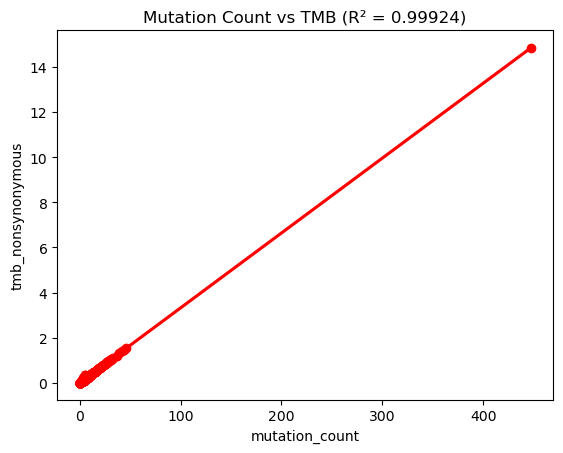

In [381]:
# Compute Linear Regression Plot R²
slope, intercept, r_value, p_value, std_err = linregress(breast_merge_exp['mutation_count'], breast_merge_exp['tmb_nonsynonymous'])
sns.regplot(x='mutation_count', y='tmb_nonsynonymous', data=breast_merge_exp, scatter_kws={'alpha':1}, color='red')
plt.title(f"Mutation Count vs TMB (R² = {r_value**2:.5f})")
plt.show()

/var/folders/vl/g1lknmm556zdfxf755g8vzv00000gn/T/ipykernel_29516/1058796341.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='patients_vital_status', y='Total_Pathways', data=breast_merge_exp, showfliers=False, palette=['brown', 'yellow'])


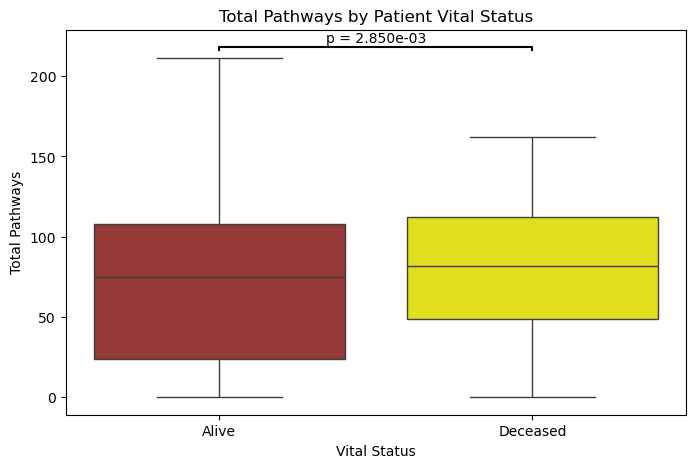

In [382]:
# Boxplots

# Total Pathways
# Separate the two groups

alive_path = breast_merge_exp[breast_merge_exp['patients_vital_status'] == 'Alive']['Total_Pathways']
deceased_path = breast_merge_exp[breast_merge_exp['patients_vital_status'] == 'Deceased']['Total_Pathways']

# Perform t-test
t_stat, p_value = ttest_ind(alive_path, deceased_path, equal_var=False) 

plt.figure(figsize=(8,5))  # Set figure size

sns.boxplot(x='patients_vital_status', y='Total_Pathways', data=breast_merge_exp, showfliers=False, palette=['brown', 'yellow'])
plt.title('Total Pathways by Patient Vital Status')
plt.xlabel('Vital Status')
plt.ylabel('Total Pathways')
# Annotate p-value on the plot
x1, x2 = 0, 1  # set position of p-value
y, h = max(breast_merge_exp['Total_Pathways']) + 5, 2  # y position of annotation
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
plt.text((x1+x2)*0.5, y+h+1, f"p = {p_value:.3e}", ha='center', va='bottom', fontsize=10)
plt.show()

             Patient Vital Status  count
Tumour Stage                            
T0                  AliveDeceased      5
T1                          Alive      6
T1C                 AliveDeceased      3
T1a                 AliveDeceased     39
T1b                 AliveDeceased    184
T1c                 AliveDeceased    548
T1mi                AliveDeceased     10
T2                  AliveDeceased    564
T3                  AliveDeceased    138
T4                  AliveDeceased     15
T4a                 AliveDeceased      9
T4b                 AliveDeceased     67
T4c                 AliveDeceased      9
T4d                 AliveDeceased     34
TX                  AliveDeceased    253
Tis                         Alive      1
   Tumour Stage Patient Vital Status  count  Survival Rate by Stage%
0            T0                Alive      4                80.000000
1            T0             Deceased      1                20.000000
2            T1                Alive      6            

/var/folders/vl/g1lknmm556zdfxf755g8vzv00000gn/T/ipykernel_29516/1281823487.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[xlab]=data[stage_class]
/var/folders/vl/g1lknmm556zdfxf755g8vzv00000gn/T/ipykernel_29516/1281823487.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Patient Vital Status']=data['patients_vital_status']


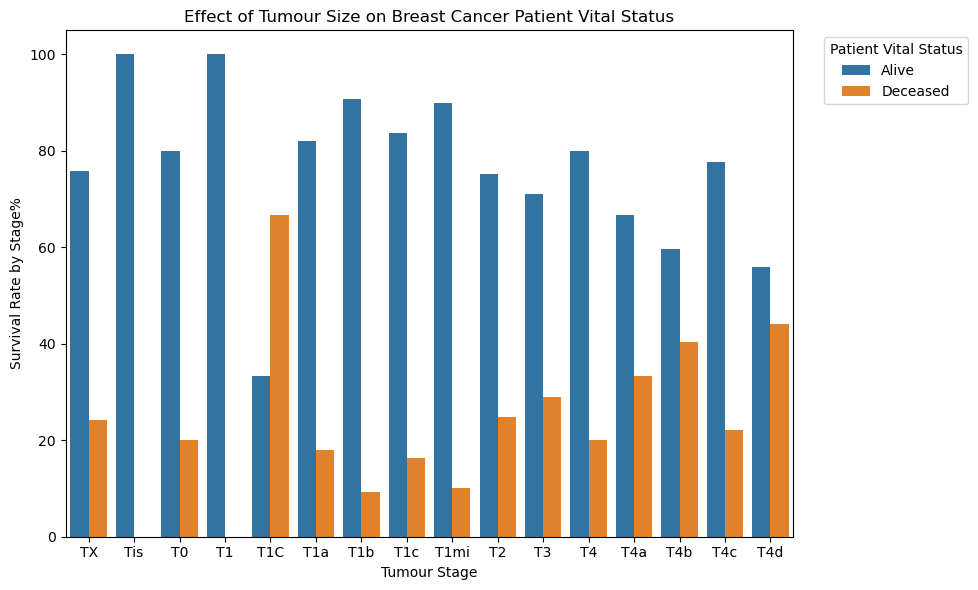

/var/folders/vl/g1lknmm556zdfxf755g8vzv00000gn/T/ipykernel_29516/1281823487.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[xlab]=data[stage_class]
/var/folders/vl/g1lknmm556zdfxf755g8vzv00000gn/T/ipykernel_29516/1281823487.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Patient Vital Status']=data['patients_vital_status']


           Patient Vital Status  count
Node Stage                            
N0                AliveDeceased    769
N0(i+)            AliveDeceased     17
N1                AliveDeceased    101
N1a               AliveDeceased    329
N1b                       Alive      1
N1c                       Alive      2
N1mi              AliveDeceased     51
N2                AliveDeceased     13
N2a               AliveDeceased    174
N2b               AliveDeceased      9
N3                        Alive      3
N3a               AliveDeceased    141
N3b               AliveDeceased     11
N3c               AliveDeceased     10
NX                AliveDeceased    254
   Node Stage Patient Vital Status  count  Survival Rate by Stage%
0          N0                Alive    659                85.695709
1          N0             Deceased    110                14.304291
2      N0(i+)                Alive     15                88.235294
3      N0(i+)             Deceased      2                11.764706
4 

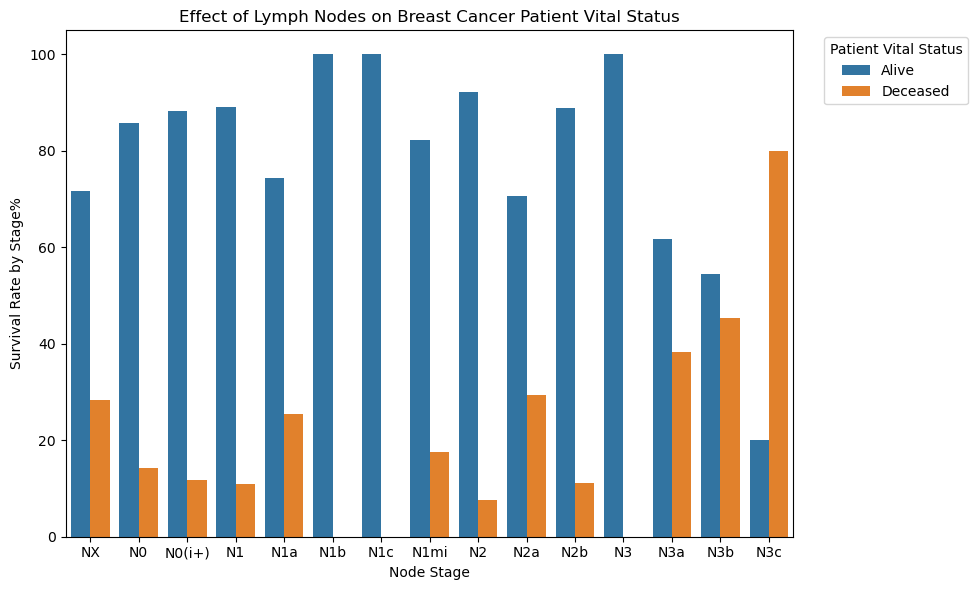

                 Patient Vital Status  count
Metastasis Stage                            
M0                      AliveDeceased   1502
M1                      AliveDeceased    383
  Metastasis Stage Patient Vital Status  count  Survival Rate by Stage%
0               M0                Alive   1190                79.227696
1               M0             Deceased    312                20.772304
2               M1                Alive    287                74.934726
3               M1             Deceased     96                25.065274


/var/folders/vl/g1lknmm556zdfxf755g8vzv00000gn/T/ipykernel_29516/1281823487.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[xlab]=data[stage_class]
/var/folders/vl/g1lknmm556zdfxf755g8vzv00000gn/T/ipykernel_29516/1281823487.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Patient Vital Status']=data['patients_vital_status']


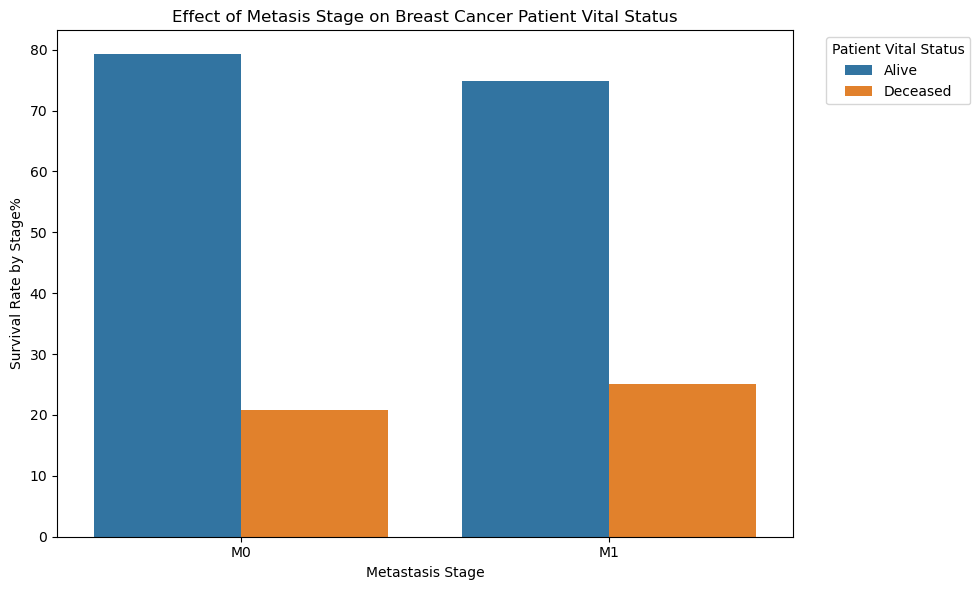

/var/folders/vl/g1lknmm556zdfxf755g8vzv00000gn/T/ipykernel_29516/1281823487.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[xlab]=data[stage_class]
/var/folders/vl/g1lknmm556zdfxf755g8vzv00000gn/T/ipykernel_29516/1281823487.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Patient Vital Status']=data['patients_vital_status']


                               Patient Vital Status  count
Menopausal Status at Diagnosis                            
Male                                  AliveDeceased     11
Peri                                  AliveDeceased    113
Post                                  AliveDeceased    883
Pre                                   AliveDeceased    878
  Menopausal Status at Diagnosis Patient Vital Status  count  \
0                           Male                Alive      6   
1                           Male             Deceased      5   
2                           Peri                Alive     92   
3                           Peri             Deceased     21   
4                           Post                Alive    692   
5                           Post             Deceased    191   
6                            Pre                Alive    687   
7                            Pre             Deceased    191   

   Survival Rate by Stage%  
0                54.545455  
1          

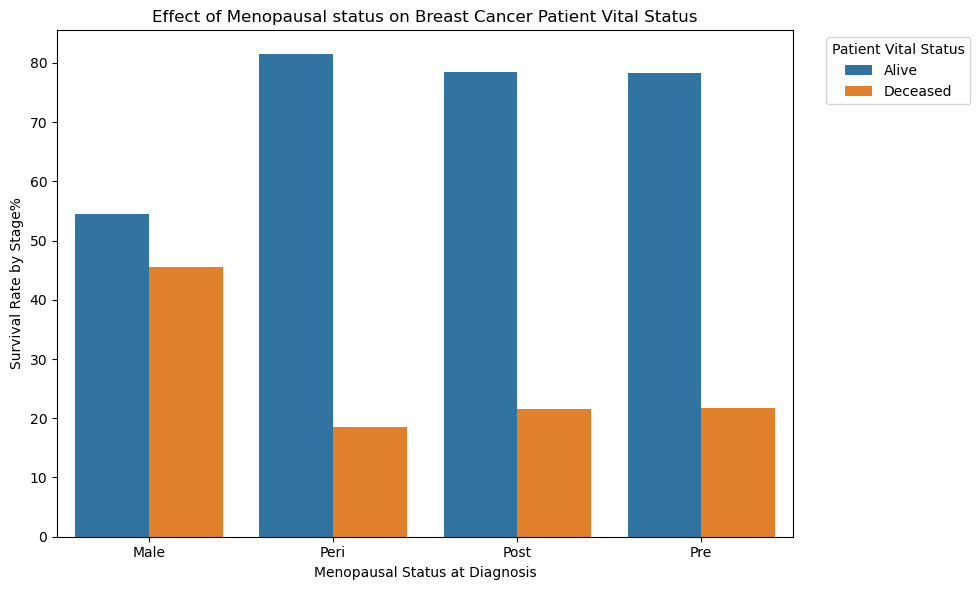

In [383]:
T_stage_order = ['TX','Tis','T0', 'T1', 'T1C', 'T1a', 'T1b', 'T1c','T1mi','T2', 'T3',
 'T4', 'T4a', 'T4b', 'T4c', 'T4d'] 
N_stage_order = ['NX','N0', 'N0(i+)', 'N1','N1a', 'N1b', 'N1c', 'N1mi','N2',
 'N2a', 'N2b', 'N3', 'N3a', 'N3b', 'N3c']
M_stage_order=['M0', 'M1']

def percent_counts_barplot(stage_class, title, stage_order=None, xlab=None):
    data=breast_merge_exp
    data[xlab]=data[stage_class]
    data['Patient Vital Status']=data['patients_vital_status']
    counts = (data
              .groupby([xlab, 'Patient Vital Status']).size().reset_index(name='count')) 
    print(counts.groupby(xlab).sum())
   
    counts['Survival Rate by Stage%'] = counts.groupby(xlab)['count'].transform(lambda x: 100 * x / x.sum())
    print(counts)
    plt.figure(figsize=(10,6))
    plt.title(title)
    ax=sns.barplot(data=counts, x=xlab, y='Survival Rate by Stage%', hue='Patient Vital Status', order=stage_order)


    # ---- ADD: combine Patient Vital Status and survival info into one legend ----
    # Get existing legend handles/labels (Alive/Deceased)
    handles, labels = ax.get_legend_handles_labels()

    

    # Combine handles and labels
    combined_handles = handles 
    combined_labels = labels 

    # One unified legend
    ax.legend(
        handles=combined_handles,
        labels=combined_labels,
        title="Patient Vital Status",
        loc='upper right',
        bbox_to_anchor=(1.25, 1)
    )

    plt.tight_layout()
    plt.show()



percent_counts_barplot('t_stage', title='Effect of Tumour Size on Breast Cancer Patient Vital Status', stage_order=T_stage_order, xlab='Tumour Stage')
percent_counts_barplot('n_stage', title='Effect of Lymph Nodes on Breast Cancer Patient Vital Status', stage_order=N_stage_order, xlab='Node Stage')
percent_counts_barplot('m_stage', title='Effect of Metasis Stage on Breast Cancer Patient Vital Status', stage_order=M_stage_order, xlab='Metastasis Stage')
percent_counts_barplot('menopausal_status_at_diagnosis', title='Effect of Menopausal status on Breast Cancer Patient Vital Status', xlab='Menopausal Status at Diagnosis')

/var/folders/vl/g1lknmm556zdfxf755g8vzv00000gn/T/ipykernel_29516/245472239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_merge_exp['tmb_class']=pd.qcut(breast_merge_exp['tmb_nonsynonymous'], q=2, labels=['Low', 'High'])


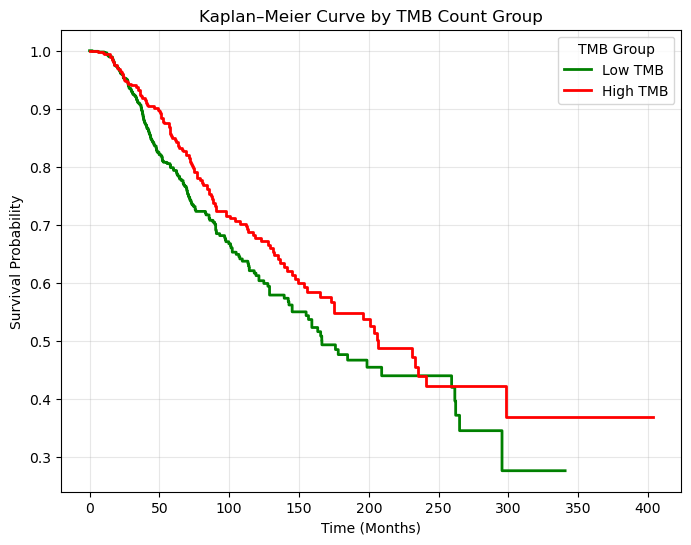

In [384]:
# Kaplan Meier Curve
breast_merge_exp['tmb_class']=pd.qcut(breast_merge_exp['tmb_nonsynonymous'], q=2, labels=['Low', 'High'])
breast_merge_exp[['tmb_nonsynonymous', 'tmb_class']]

def plot_KM_curve(df):
    df['event']=df['patients_vital_status'].apply(lambda x: 1 if x=='Deceased' else 0)
    df['tmb_group']=pd.qcut(df['tmb_nonsynonymous'], q=2, labels=['Low', 'High'])
    # Initialize the Kaplan–Meier fitter
    kmf_low = KaplanMeierFitter()
    kmf_high = KaplanMeierFitter()

     # Split data
    low = df[df['tmb_group'] == 'Low']
    high = df[df['tmb_group'] == 'High']

     # Fit both groups
    kmf_low.fit(durations=low['overall_survival_months'], event_observed=low['event'], label='Low TMB')
    kmf_high.fit(durations=high['overall_survival_months'], event_observed=high['event'], label='High TMB')

    # Plot both on the same figure
    plt.figure(figsize=(8,6))
    ax = kmf_low.plot(ci_show=False, color='green', linewidth=2)
    kmf_high.plot(ax=ax, ci_show=False, color='red', linewidth=2)        
    plt.title('Kaplan–Meier Curve by TMB Count Group')
    plt.xlabel('Time (Months)')
    plt.ylabel('Survival Probability')
    plt.legend(title='TMB Group')
    plt.grid(alpha=0.3)
    plt.show()

plot_KM_curve(train_data)

#### Data One-Hot Encoding

In [57]:
y = breast_cancer_merged_cl['patients_vital_status']
X = breast_cancer_merged_cl.drop(columns=['patients_vital_status'])
X=pd.get_dummies(X, drop_first=False, dtype=int)
y=y.apply(lambda x:0 if x=='Alive' else 1)

#### Training/Test Split

In [58]:

X_train, X_test, y_train, y_test = train_test_split(
X, y, 
test_size=0.2,      # 20% test set
 random_state=42,    # for reproducibility
)

#### Data Imputation

In [59]:
# Makes rational sense to impute 0 for rows that had no mutation counsts and did not have any pathway hits
columns_to_impute=['mutation_count', 'Total_Pathways']
X_train[columns_to_impute]=X_train[columns_to_impute].fillna(0)
X_test[columns_to_impute]=X_test[columns_to_impute].fillna(0)



# For the metasis recurrence time it would be more appropriate to fill with the mean value
X_train['metastatic_recurrence_time'] = X_train['metastatic_recurrence_time'].fillna(X_train['metastatic_recurrence_time'].mean())
X_test['metastatic_recurrence_time'] = X_test['metastatic_recurrence_time'].fillna(X_train['metastatic_recurrence_time'].mean())

In [66]:
X_train.shape

(1508, 74)

In [271]:
X_test.to_csv('X_test.csv')
X_train.to_csv('X_train.csv')
y_test.to_csv('y_test.csv')
y_train.to_csv('y_train.csv')

#### Data Scaling

In [67]:
# Initialize scaler
scaler = StandardScaler()

# Fit scaler to only the numeric columns in the training data
scaler.fit(X_train[cols_to_scale])

# Transform both X_train and X_test using the fitted scaler

X_train_scaled = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled = scaler.fit_transform(X_test[cols_to_scale])

# Replace orginial columns with scaled columns
X_train[cols_to_scale]=X_train_scaled
X_test[cols_to_scale]=X_test_scaled


#### Model Selection and Initialization

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np



# Logistic Regression
lr = LogisticRegression(random_state=1)
# Random Forest
rf = RandomForestClassifier(random_state=1)
# XGBoost
xgb = XGBClassifier(random_state=1)
# CatBoost
cat = CatBoostClassifier(random_state=1)

#### Hyperparameter Tuning and Training

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'subsample': 1.0}


<Axes: >

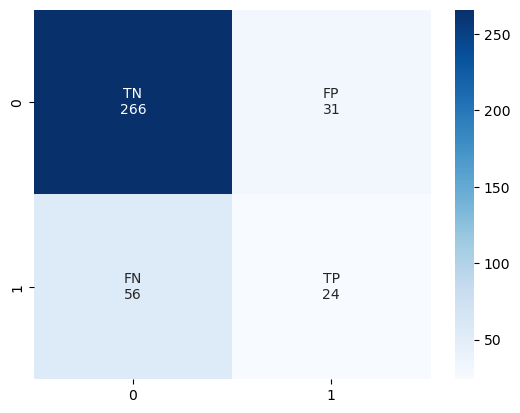

In [73]:
# XGB Hyperparamter Selection
# Source for pub: https://www.mdpi.com/1424-8220/24/4/1230

param_grid_xgb = {
    'n_estimators': [200, 500, 800],
    'max_depth': [3, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
}
# Initialize 5-fold Cross-Validation
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search=GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Choose best params
best_params=grid_search.best_params_

# Train on best parameters
xgb_best=XGBClassifier(**best_params, random_state=42)
xgb_best.fit(X_train, y_train)

y_pred_xgb=xgb_best.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
# Print Best Params
print('Best Parameters:', grid_search.best_params_)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
# Create labels for each cell
labels = np.array([['TN', 'FP'],
                   ['FN', 'TP']])

# Combine labels with counts
annot = np.empty_like(cm).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{labels[i, j]}\n{cm[i, j]}"

# Print Confusion Matrix
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues')




0:	learn: 0.6748075	total: 59.2ms	remaining: 17.7s
0:	learn: 0.6737861	total: 59.2ms	remaining: 17.7s
0:	learn: 0.6778763	total: 59.2ms	remaining: 17.7s
1:	learn: 0.6532975	total: 60.4ms	remaining: 9.01s
1:	learn: 0.6530589	total: 60.3ms	remaining: 8.98s
2:	learn: 0.6383803	total: 60.9ms	remaining: 6.03s
1:	learn: 0.6561691	total: 60.6ms	remaining: 9.03s
2:	learn: 0.6425940	total: 61.4ms	remaining: 6.08s
3:	learn: 0.6206701	total: 62.6ms	remaining: 4.63s
2:	learn: 0.6391407	total: 63.1ms	remaining: 6.25s
4:	learn: 0.6074063	total: 63.3ms	remaining: 3.73s
3:	learn: 0.6240718	total: 63.4ms	remaining: 4.69s
3:	learn: 0.6209215	total: 64.5ms	remaining: 4.77s
5:	learn: 0.5924738	total: 64.3ms	remaining: 3.15s
6:	learn: 0.5796977	total: 65.1ms	remaining: 2.72s
4:	learn: 0.6128195	total: 64.8ms	remaining: 3.82s
4:	learn: 0.6077931	total: 65.8ms	remaining: 3.88s
5:	learn: 0.5968480	total: 65.5ms	remaining: 3.21s
7:	learn: 0.5671753	total: 65.8ms	remaining: 2.4s
5:	learn: 0.6000832	total: 67ms	

<Axes: >

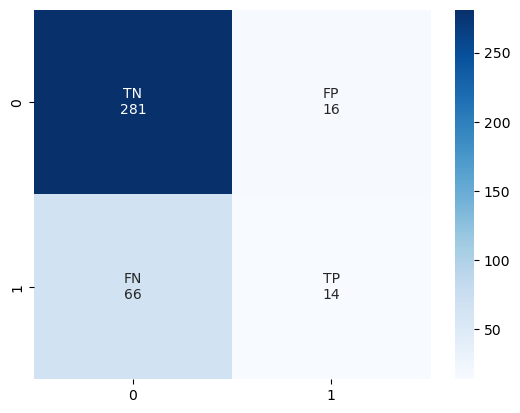

In [69]:
# CatBoost Hyperparameter Selection
# Source for pub: https://pmc.ncbi.nlm.nih.gov/articles/PMC11430446/?utm_source=chatgpt.com

# Select Hyperparameters
param_grid_cat = {
    'iterations': [300, 800],
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1],
    'subsample': [0.7, 1.0],
}

# Initialize 5-fold Cross-Validation
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search=GridSearchCV(
    estimator=cat,
    param_grid=param_grid_cat,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Choose best params
best_params=grid_search.best_params_

# Train on best parameters
cat_best=CatBoostClassifier(**best_params, random_state=42)
cat_best.fit(X_train, y_train)

y_pred_cat=cat_best.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_cat)
# Print Best Params
print('Best Parameters:', grid_search.best_params_)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_cat)
# Create labels for each cell
labels = np.array([['TN', 'FP'],
                   ['FN', 'TP']])

# Combine labels with counts
annot = np.empty_like(cm).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{labels[i, j]}\n{cm[i, j]}"

# Print Confusion Matrix
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues')



Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


<Axes: >

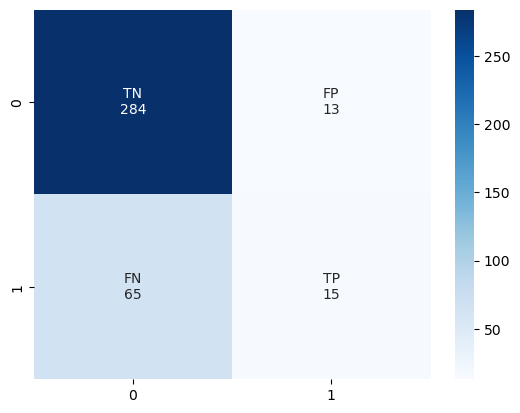

In [70]:
# RandomForest Hyperparameter Selection
# Source for Pub: https://www.mdpi.com/2073-4433/12/2/238?utm_source=chatgpt.com
param_grid_rf = {
    'n_estimators': [100, 500, 1000],  
    'max_depth': [None, 20, 50],     
    'min_samples_split': [2, 10],      
    'min_samples_leaf': [1, 4]         
}


# Initialize 5-fold Cross-Validation
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search=GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Choose best params
best_params=grid_search.best_params_

# Train on best parameters
rf_best=RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

y_pred_rf=rf_best.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
# Print Best Params
print('Best Parameters:', grid_search.best_params_)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
# Create labels for each cell
labels = np.array([['TN', 'FP'],
                   ['FN', 'TP']])

# Combine labels with counts
annot = np.empty_like(cm).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{labels[i, j]}\n{cm[i, j]}"

# Print Confusion Matrix
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues')


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max

<Axes: >

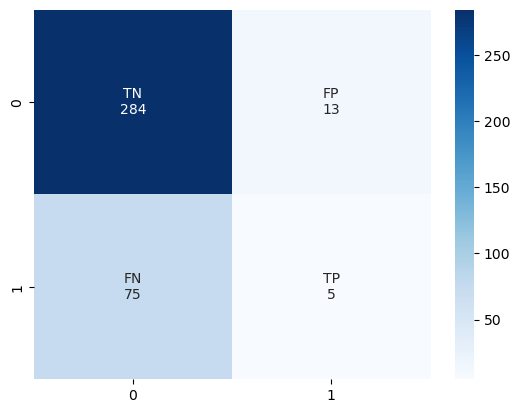

In [72]:
# Logistic Regression Hyperparameter Selection
# Source for Pub: https://pmc.ncbi.nlm.nih.gov/articles/PMC11187433/?utm_source=chatgpt.com
param_grid_lr = [
    {'penalty': ['l1'], 'C': [0.1, 1, 10], 'solver': ['liblinear','saga']},
    {'penalty': ['l2'], 'C': [0.1, 1, 10], 'solver': ['liblinear','lbfgs','saga']},
    {'penalty': ['elasticnet'], 'C': [0.1, 1, 10], 'solver': ['saga'], 'l1_ratio':[0.5]}
]



# Initialize 5-fold Cross-Validation
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search=GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Choose best params
best_params=grid_search.best_params_

# Train on best parameters
lr_best=LogisticRegression(**best_params, random_state=42)
lr_best.fit(X_train, y_train)

y_pred_lr=lr_best.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
# Print Best Params
print('Best Parameters:', grid_search.best_params_)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
# Create labels for each cell
labels = np.array([['TN', 'FP'],
                   ['FN', 'TP']])

# Combine labels with counts
annot = np.empty_like(cm).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = f"{labels[i, j]}\n{cm[i, j]}"

# Print Confusion Matrix
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues')


#### Determing Optimal Model 

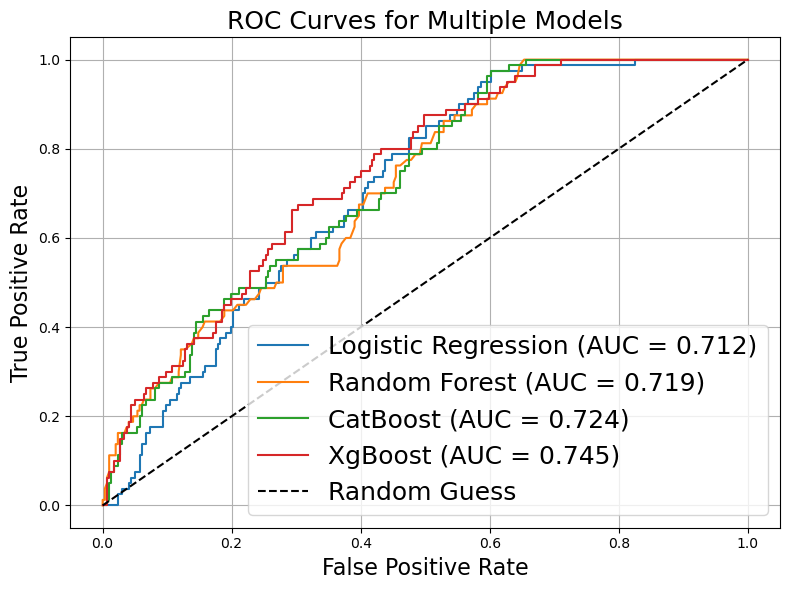

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

models = {
    'Logistic Regression': lr_best,
    'Random Forest': rf_best,
    'CatBoost': cat_best,
    'XgBoost': xgb_best
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Get predicted probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    # Plot each ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

# ---- Plot formatting ----
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('ROC Curves for Multiple Models', fontsize = 18)
plt.legend(loc='lower right', fontsize = 18)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Determine the Top Contributers to Prognosis using SHAP values 

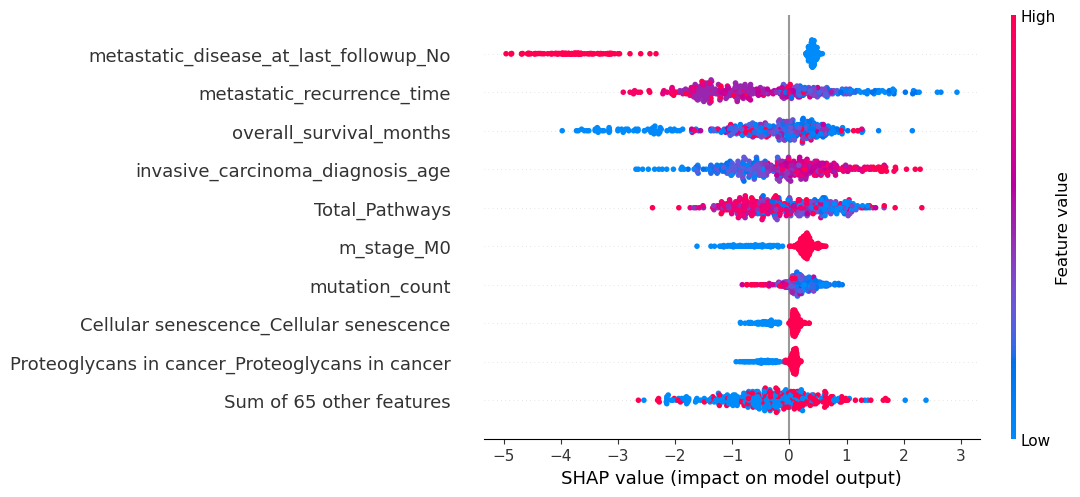

Exception ignored in: <function ResourceTracker.__del__ at 0x10498dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107485bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1051fdbc0>
Traceback (most recent call last

In [ ]:
# For Tree based models
explainer = shap.TreeExplainer(xgb_best)
shap_values=explainer(X_test)
shap.plots.beeswarm(shap_values)

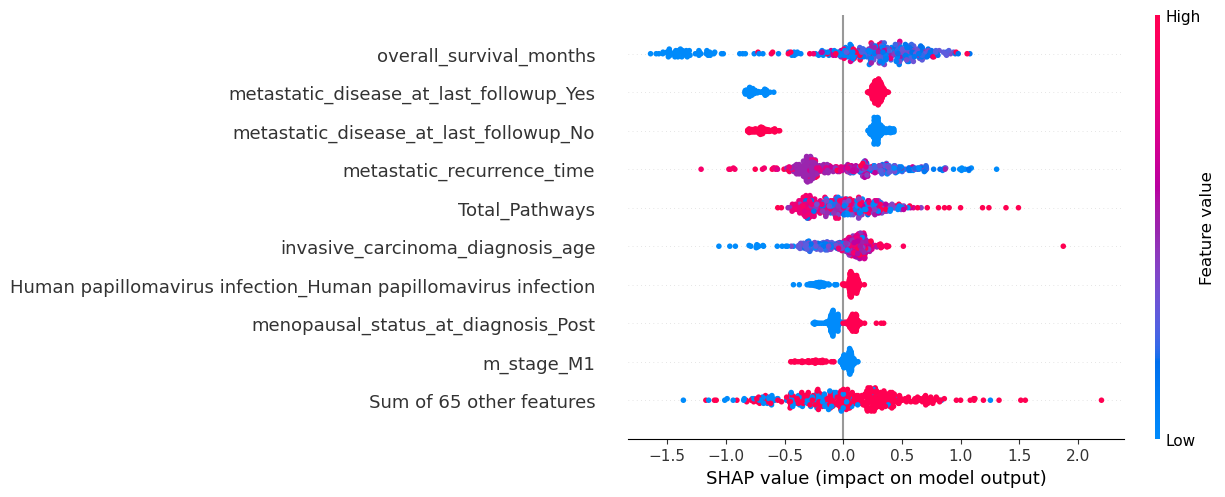

In [77]:
# For Tree based models
explainer = shap.TreeExplainer(cat_best)
shap_values=explainer(X_test)
shap.plots.beeswarm(shap_values)


In [13]:
breast_cancer_merged_cl = pd.read_csv('merged_breast_cancer_cl_v2.csv')

In [18]:
breast_cancer_merged_cl['Patient Vital Status']=breast_cancer_merged_cl['patients_vital_status']